## 207 -Applied Machine Learning Project: Predicting Attrition of an Online Store Site

#### Authors:

Diego Moss\
Sammy Cayo\
Conor Huh\
Roz Huang\
Jasmine Lau



In [2]:
# system for file import
import sys

# basic python lib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

"""google query modules, please remove before running the final notebook for submission"""

# from google.colab import auth
# from google.cloud import bigquery 
# from google.colab import drive

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model preprocessing libaries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences


# tensorflow model libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers import Input, LSTM, Dense, Concatenate, Masking, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# metrics
from keras.metrics import BinaryAccuracy, Recall, Precision, F1Score, AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score




pd.set_option('display.max_columns', 30)

## Loading Data from BigQuery and Binding Rows

In [ ]:
## code block for initial data loading
def query_data():
  sys.path.append('/content/src/bq-helper')
  from bq_helper import BigQueryHelper
  !pip install -e git+https://github.com/ConorHuh/BigQuery_Helper#egg=bq_helper
  auth.authenticate_user()
  project_id = "final-project-430217" # change this to correct project ID
  client = bigquery.Client(project=project_id)

  google_analytics = BigQueryHelper(active_project="bigquery-public-data",
                                    dataset_name="data:google_analytics_sample",
                                    project_id=project_id)

table_names = []
all_data = []
all_hits_data = []

start_date = datetime(2016, 8, 1)
end_date = datetime(2017, 8, 1)
current_date = start_date
count = 0
while current_date <= end_date:
    table_name = f"ga_sessions_{current_date.strftime('%Y%m%d')}"
    query = f"""
    SELECT *
    FROM `bigquery-public-data.google_analytics_sample.{table_name}`
    """
    table_names.append(table_name)
    df = google_analytics.query_to_pandas(query)

    totals = pd.json_normalize(df['totals'])
    totals.columns = ['total_' + col for col in totals.columns]
    df = pd.concat([df.drop(columns=['totals']), totals], axis=1)

    source = pd.json_normalize(df['trafficSource'])
    source.columns = ['trafficSource_' + col for col in source.columns]
    df = pd.concat([df.drop(columns=['trafficSource']), source], axis=1)

    device = pd.json_normalize(df['device'])
    device.columns = ['device_' + col for col in device.columns]
    df = pd.concat([df.drop(columns=['device']), device], axis=1)

    network = pd.json_normalize(df['geoNetwork'])
    network.columns = ['geoNetwork_' + col for col in network.columns]
    df = pd.concat([df.drop(columns=['geoNetwork']), network], axis=1)

    custom_dimensions = pd.json_normalize(df.explode('customDimensions')['customDimensions'])
    custom_dimensions.columns = ['customDimensions_' + col for col in custom_dimensions.columns]
    df = pd.concat([df.drop(columns=['customDimensions']), custom_dimensions], axis=1)

    df.to_csv(f'{table_name}.csv')
    all_data.append(df)

    hits_df = pd.json_normalize(df.explode('hits')['hits'])
    hit_length = df['hits'].apply(len)
    repeated_visit_ids = pd.DataFrame(np.repeat(df['visitId'].values, df['hits'].apply(len)), columns=['visitID'])

    repeated_visit_ids = pd.DataFrame(np.repeat(df[['visitId', 'fullVisitorId', 'date']].values, 
                                                hit_length, axis=0), 
                                                columns=['visitId', 'fullVisitorId', 'date'])
    hits_df = pd.concat([repeated_visit_ids, hits_df], axis=1)
    # hits_df.to_csv(f'{table_name}_hits.csv')
    all_hits_data.append(hits_df)
    count += 1
    print(f'{count}:366, {current_date}')
    current_date += timedelta(days=1)

final_df = pd.concat(all_data, ignore_index=True)
final_hits_df = pd.concat(all_hits_data, ignore_index=True)

final_df.to_csv('all_data.csv', index=False)
final_hits_df.to_csv('all_hits_data.csv', index=False)
 


## Load Data from Google Drive

In [ ]:
# Connect to GDrive

drive.mount('/content/drive')

In [ ]:
DF_DATA_PATH = '/content/drive/MyDrive/google_analytics_sample/all_data.csv'
HITS_DATA_PATH = '/content/drive/MyDrive/google_analytics_sample/all_hits_data.csv'
def load_final_df(path):
    df = pd.read_csv(path)
    return df
df = load_final_df(DF_DATA_PATH)
hits_df = load_final_df(HITS_DATA_PATH)

In [ ]:
# Debugging...
print(df['date'])
# Convert the 'date' column to string, then to datetime
df['date'] = df['date'].astype(str)
df['date0'] = pd.to_datetime(df['date'], format='%Y%m%d')
print(df['date0'])

df['year_month'] = df['date0'].dt.to_period('M')
print(df['year_month'])

In [ ]:
# drop all unnecessary columns from hits_df
columns_to_retain = ['visitId', 'fullVisitorId', 'date', 'eCommerceAction.action_type']
hits_df = hits_df[columns_to_retain]
print(hits_df.head())

# map the eCommerceAction.action_type field to their semantic values
action_type_mapping = {
    1: 'num_product_list_views',
    2: 'num_product_detail_views',
    3: 'num_ATC',
    4: 'num_RFC',
    5: 'num_Checkout',
    6: 'num_Purchase',
    7: 'num_Refund'
}

# Initialize the columns for the result
for action in action_type_mapping.values():
    hits_df[action] = 0

# Aggregate the action_type counts for each group
aggregated_df = hits_df.groupby(['fullVisitorId', 'date']).agg( # group only by visitorID and date
    num_product_list_views=('eCommerceAction.action_type', lambda x: (x == 1).sum()),
    num_product_detail_views=('eCommerceAction.action_type', lambda x: (x == 2).sum()),
    num_ATC=('eCommerceAction.action_type', lambda x: (x == 3).sum()),
    num_RFC=('eCommerceAction.action_type', lambda x: (x == 4).sum()),
    num_Checkout=('eCommerceAction.action_type', lambda x: (x == 5).sum()),
    num_Purchase=('eCommerceAction.action_type', lambda x: (x == 6).sum()),
    num_Refund=('eCommerceAction.action_type', lambda x: (x == 7).sum())
).reset_index()

print(aggregated_df.head())


In [ ]:
# Sanity Check to make sure we haven't lost data
print(aggregated_df.shape)
print(len(aggregated_df['fullVisitorId'].unique())) # 566,477
print(len(hits_df['fullVisitorId'].unique())) # 566,477
print(len(hits_df['visitId'].unique())) #694,649
print(len(df['fullVisitorId'].unique())) # 718,161
print(df.columns)


In [ ]:
# Merge the two dfs:

# Convert the two dataframe fullVisitorId and date fields to matching types
df['fullVisitorId'] = df['fullVisitorId'].astype(str)
aggregated_df['fullVisitorId'] = aggregated_df['fullVisitorId'].astype(str)
df['date'] = df['date'].astype(str)
aggregated_df['date'] = aggregated_df['date'].astype(str)

# Merge
df_merged = pd.merge(df, aggregated_df, on=['fullVisitorId', 'date'], how='left')

# Fill empty columns with 0 rather than dropping
action_columns = ['num_product_list_views', 'num_product_detail_views', 'num_ATC', 'num_RFC', 'num_Checkout', 'num_Purchase', 'num_Refund']
df_merged[action_columns] = df_merged[action_columns].fillna(0)
df_merged.head()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert 'date' to datetime format and extract year and month
df_merged['date'] = df_merged['date'].astype(str)
df_merged['date'] = pd.to_datetime(df_merged['date'], format='%Y%m%d')
df_merged['year_month'] = df_merged['date'].dt.to_period('M')
print(df_merged['year_month'])

# Sort the dataframe
df_merged = df_merged.sort_values(by=['fullVisitorId', 'year_month'])

# Define feature columns
feature_columns = [
    "fullVisitorId",
    "visitNumber",
    "year_month",
    "total_hits",
    "total_pageviews",
    "total_screenviews",
    "total_sessionQualityDim",
    "total_timeOnSite",
    "total_totalTransactionRevenue",
    "total_transactions",
    "trafficSource_source",
    "socialEngagementType",
    "channelGrouping",
    "device_browser",
    "device_operatingSystem",
    "device_deviceCategory",
    "geoNetwork_continent",
    "geoNetwork_subContinent",
    "geoNetwork_country",
    "geoNetwork_region",
    "geoNetwork_metro",
    "geoNetwork_city",
    "num_product_list_views",
    "num_product_detail_views",
    'num_ATC',
    'num_RFC',
    'num_Checkout',
    'num_Purchase',
    'num_Refund'
]

df_merged = df_merged[feature_columns]

# Define numeric and non-numeric columns
numeric_columns = [
    "visitNumber",
    "total_hits",
    "total_pageviews",
    "total_screenviews",
    "total_sessionQualityDim",
    "total_timeOnSite",
    "total_totalTransactionRevenue",
    "total_transactions",
    "num_product_list_views",
    "num_product_detail_views",
    'num_ATC',
    'num_RFC',
    'num_Checkout',
    'num_Purchase',
    'num_Refund'
]

non_numeric_columns = [
    "trafficSource_source",
    "socialEngagementType",
    "channelGrouping",
    "device_browser",
    "device_operatingSystem",
    "device_deviceCategory",
    "geoNetwork_continent",
    "geoNetwork_subContinent",
    "geoNetwork_country",
    "geoNetwork_region",
    "geoNetwork_metro",
    "geoNetwork_city",
]

# Encode non-numeric columns
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    df_merged[col] = le.fit_transform(df_merged[col].astype(str))
    label_encoders[col] = le

# Aggregate data by 'fullVisitorId' and 'year_month'
agg_funcs = {col: 'sum' for col in numeric_columns}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_columns})

df_agg = df_merged.groupby(['fullVisitorId', 'year_month']).agg(agg_funcs).reset_index()

unique_users = df_agg['fullVisitorId'].unique()
unique_year_months = df_agg['year_month'].unique()

# - 2 because fullVisitorId and year_month are not features
array_shape = (len(unique_users), len(feature_columns) - 2, len(unique_year_months))
array_3d = np.zeros(array_shape, dtype=np.float32)

# Create a dictionary to map fullVisitorId and year_month to index
user_index = {user: i for i, user in enumerate(unique_users)}
date_index = {date: j for j, date in enumerate(unique_year_months)}

for row in df_agg.itertuples(index=False):
    user_idx = user_index[row.fullVisitorId]
    date_idx = date_index[row.year_month]

    # Numeric values
    array_3d[user_idx, 0:len(numeric_columns), date_idx] = [getattr(row, col) for col in numeric_columns]

    # Non-numeric values
    array_3d[user_idx, len(numeric_columns):, date_idx] = [getattr(row, col) for col in non_numeric_columns]

print(array_3d.shape)
print(array_3d.nbytes)
print(array_3d)

In [ ]:
# Save features to GDrive
np.save('/content/drive/MyDrive/google_analytics_sample/features_with_hits.npy', array_3d)

In [ ]:
features_with_hits = np.load('/content/drive/MyDrive/google_analytics_sample/features_with_hits.npy')

In [ ]:
print(features_with_hits.shape)
print(features_with_hits[0])
stable_features = np.mean(features_with_hits, axis=2)
print(stable_features.shape)
print(stable_features[0])

In [ ]:
np.save('/content/drive/MyDrive/google_analytics_sample/stable_features.npy', stable_features)

## Initial Data Pre-Processing and Feature Extraction

#### Create Binary Target Variable

In [ ]:
# DF_DATA_PATH = '../features_with_hits.npy'
# data = np.load(DF_DATA_PATH)


# STABLE_DF_DATA_PATH = '../stable_features.npy'
# data_stable = np.load(STABLE_DF_DATA_PATH)

# print(data.shape, data_stable.shape)


"""temp path for local machine, ***please remove for final submisson***"""
DF_DATA_PATH = '/Users/sacayo/github/w207/Final_project/DATASCI-207-Applied-Machine-Learning/features_with_hits.npy'
data = np.load(DF_DATA_PATH)


STABLE_DF_DATA_PATH = '/Users/sacayo/github/w207/Final_project/DATASCI-207-Applied-Machine-Learning/stable_features.npy'
data_stable = np.load(STABLE_DF_DATA_PATH)

print(data.shape, data_stable.shape)

In [ ]:
num_users, num_features, num_months= data.shape

y = np.zeros((num_users, num_months), dtype=int)

for month_idx in range(num_months - 1):    
    # Check if there is any non-zero activity in the subsequent months
    subsequent_activity = np.any(data[:, :, month_idx + 1:] > 0, axis=(1, 2))
    y[:, month_idx] = subsequent_activity.astype(int)

print(y.shape)

In [ ]:
num_users, num_months = y.shape
flattened_y = y.flatten()

# Count occurrences of each class
unique, counts = np.unique(flattened_y, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Count occurrences of each class for each month
monthly_class_distribution = {}

for month_idx in range(num_months):
    month_labels = y[:, month_idx]
    unique, counts = np.unique(month_labels, return_counts=True)
    monthly_class_distribution[month_idx] = dict(zip(unique, counts))

# Print monthly class distributions
for month, distribution in monthly_class_distribution.items():
    print(f"Month {month}: {distribution}")

# Extract data from the dictionary
months = list(monthly_class_distribution.keys())
class_0_counts = [monthly_class_distribution[month].get(0, 0) for month in months]
class_1_counts = [monthly_class_distribution[month].get(1, 0) for month in months]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
index = np.arange(len(months))
bar1 = ax.bar(index - bar_width/2, class_0_counts, bar_width, label='Class 0')
bar2 = ax.bar(index + bar_width/2, class_1_counts, bar_width, label='Class 1')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Instances')
ax.set_title('Monthly Class Distribution')
ax.set_xticks(index)
ax.set_xticklabels([f'Month {i}' for i in months])
ax.legend()
plt.tight_layout()
plt.show()

## Data Splitting (Stratify by Class)

Because our data is in 3-dimensions, we are unable to split the data across our training, validation, and test sample with the train_test_split() function directly. Thus, we create a new dataset using user indices so that we can split using the function. The output provides us with the indices that we need to filter our original data with in order to create the final training, testing, and validation sets across our X, X_stable, and y.

In [ ]:
# creating user indices to split on
user_indices = np.arange(num_users)

# Reshape indices to (n, 1) so can concatenate with Y array
user_indices = user_indices.reshape(-1, 1)

y_w_indices = np.hstack((y, user_indices))


# stable features
data_stable_combined = np.hstack((data_stable, user_indices))


# Expanding dimensions to match (n, 1, 13) for X set
user_indices_expanded = np.repeat(user_indices[:, np.newaxis], num_months, axis=2)

# adding to data so we can filter by index after splitting
combined_data = np.concatenate((data, user_indices_expanded), axis=1)

# Verify the shapes
print(f'Original Y shape: {y.shape }')
print(f'Combined Y shape: {y_w_indices.shape}')

print(f'Original Stable Data shape: {data_stable.shape}')
print(f'Combined Stable Data shape: {data_stable_combined.shape}')

print(f'Original data shape: {data.shape}')
print(f'Combined data shape: {combined_data.shape}')


In [ ]:
# WARNING THIS CHUNK TAKES A LONG TIME TO RUN

# need to loop through every user's timesteps to create sequences (extra samples), only including the current and previous timesteps without future timesteps,
# with a y that needs to be a single value predicting a user returning in a future month 

combined_data_sequences = [] # creating new data with expanded user sequences (1 month, 1-2 months, 1-3 months, etc)
combined_data_stable_sequences = [] # creating new stable feature samples from the updating sequences, so we don't get information from future timesteps
y_sequences = [] # correctly putting in whether someone returned in a future month

for j in range(num_users):
    for i in range(num_months):
         
        combined_data_sequences.append(combined_data[j, :, :i + 1])    
        combined_data_stable_sequences.append(np.mean(combined_data[j, :, :i + 1], axis = 1)) # getting mean of the stable features in
        
        # this is to set y data and make sure we aren't making any predictions if someone hasn't yet been on the site in previous timesteps
        if np.sum(np.mean(combined_data[j, :-1, :i + 1], axis = 1)) == 0: 
            y_sequences.append(np.array([j,0]))
        else:
            y_sequences.append(np.array([j , y_w_indices[j, i]]))

    print("combined_data_sequences: ", len(combined_data_sequences), "\n",
          "combined_data_stable_sequences: ", len(combined_data_stable_sequences), "\n",
          "y_sequences: " , len(y_sequences))

    



In [ ]:

# Transpose each sequence to (n timesteps, 27 features) for padding
transposed_combined = [seq.T for seq in combined_data_sequences]

# Define maximum timesteps based on the longest sequence
max_timesteps = 13

# Pad sequences to the same length
padded_combined = pad_sequences(transposed_combined, maxlen=max_timesteps, dtype='float32', padding='post', value=0.0)

# After padding, transpose back to (27 features, max_timesteps)
combined_data = np.array([seq.T for seq in padded_combined])
data_stable_combined = np.array(combined_data_stable_sequences)



In [ ]:
# need to find those who had returned at all, so we can stratify the split

# Step 1: Create a mask for non-zero elements
non_zero_mask = data != 0


non_zero_features_per_timestep = np.sum(non_zero_mask, axis=1)

# Step 3: Count the number of timesteps with non-zero features for each user
non_zero_timesteps_count = np.sum(non_zero_features_per_timestep > 0, axis=1)

return_user_indices = np.where(non_zero_timesteps_count > 1)[0]

# return_user_indices now contains the indices of the users with more than one non-zero timestep
user_ids_bool = np.isin(user_indices, return_user_indices)

# Step 3: Combine the filtered_user_ids and user_indices into a single array
return_user_array = np.column_stack((user_indices, user_ids_bool))
return_user_array.shape # two columns, user_id, and 0 or 1 if returning user



In [ ]:

# data splitting

# Split the data - 60% train, 20% validation, 20% test
train, temp = train_test_split(
    return_user_array,
    test_size=0.4,
    random_state=42,
    stratify=return_user_array[:,1]  # Stratify by returning users (not enough data to stratify by month)
)

val, test = train_test_split(
    temp,
    test_size=0.5,
    random_state=42,
    stratify=temp[:,1]  
)


# Extract the indices from the splits
train_indices = train[:, 0].astype(int)
val_indices = val[:, 0].astype(int)
test_indices = test[:, 0].astype(int)




# Filter the original X using the indices
X_train = combined_data[np.isin(combined_data[:, 27, 0], train_indices)]
X_val = combined_data[np.isin(combined_data[:, 27, 0], val_indices)]
X_test = combined_data[np.isin(combined_data[:, 27, 0], test_indices)]

# Filter the original Stable X features
X_train_stable = data_stable_combined[np.isin(data_stable_combined[:, 27], train_indices)]
X_val_stable = data_stable_combined[np.isin(data_stable_combined[:, 27], val_indices)]
X_test_stable = data_stable_combined[np.isin(data_stable_combined[:, 27], test_indices)]

# Filter the original Y using the indices
# creating y
y = np.array(y_sequences)

y_train = y[np.isin(y[:, 0], train_indices)]
y_val = y[np.isin(y[:, 0], val_indices)]
y_test = y[np.isin(y[:, 0], test_indices)]



# removing indices feature from X and Y
X_train = X_train[:, :-1, :]
X_val = X_val[:, :-1, :]
X_test = X_test[:, :-1, :]

X_train_stable = X_train_stable[:, :-1]
X_val_stable = X_val_stable[:, :-1]
X_test_stable = X_test_stable[:, :-1]

y_train = y_train[:, 1]
y_val = y_val[:, 1]
y_test = y_test[:, 1]



# Output the shapes to verify
print(f'X Training set shape: {X_train.shape}')
print(f'X Validation set shape: {X_val.shape}')
print(f'X Test set shape: {X_test.shape} \n')

print(f'Stable X Training set shape: {X_train_stable.shape}')
print(f'Stable X Validation set shape: {X_val_stable.shape}')
print(f'Stable X Test set shape: {X_test_stable.shape} \n')

print(f'Y Training set shape: {y_train.shape}')
print(f'Y Validation set shape: {y_val.shape}')
print(f'Y Test set shape: {y_test.shape}')

## Removing Most Negative Cases for Computational Efficiency

Because our sequenced data had multiplied our already large sample to a size of nearly 10 million samples, we needed to remove enough data so that we could fit and tune models within the project time limit. Below we create a function to balance out the classes by keeping all the positive cases and randomly removing the negative cases. We are sure to keep the correct indices across our sets to avoid data mismatch or data leakage. Our final model results below suggest that this selective data sampling had worked correctly.

In [ ]:
#REMOVE THIS SECTION IF WANTING TO WORK WITH ALL 9+ MILLION SAMPLES OF DATA

# Filtering data so we remove much of the data but keep all of the positive cases and an equal amount of random negative cases
# the function insures that the correct indices are kept between the training, stable, and test sets

import numpy as np

def balance_classes(X, X_stable, y):
    # Identify positive and negative cases
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y == 0)[0]
    
    # Number of positive cases
    num_positive = len(positive_indices)
    
    # Randomly sample an equal number of negative cases
    sampled_negative_indices = np.random.choice(negative_indices, num_positive, replace=False)
    
    # Combine positive cases and sampled negative cases
    balanced_indices = np.concatenate([positive_indices, sampled_negative_indices])
    
    # Shuffle the combined indices
    np.random.shuffle(balanced_indices)
    
    # Filter X, X_stable, and y based on balanced_indices
    X_balanced = X[balanced_indices]
    X_stable_balanced = X_stable[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, X_stable_balanced, y_balanced

# Assuming you have the following arrays: 
# X_train, X_val, X_test (shaped samples, timesteps, features)
# X_train_stable, X_val_stable, X_test_stable (shaped samples, features)
# y_train, y_val, y_test (shaped samples,)

# Balance the training set
X_train_balanced, X_train_stable_balanced, y_train_balanced = balance_classes(X_train, X_train_stable, y_train)

# Balance the validation set
X_val_balanced, X_val_stable_balanced, y_val_balanced = balance_classes(X_val, X_val_stable, y_val)

# Balance the test set
X_test_balanced, X_test_stable_balanced, y_test_balanced = balance_classes(X_test, X_test_stable, y_test)

# Print shapes to verify
print("X_train_balanced shape:", X_train_balanced.shape)
print("X_train_stable_balanced shape:", X_train_stable_balanced.shape)
print("y_train_balanced shape:", y_train_balanced.shape)

print("X_val_balanced shape:", X_val_balanced.shape)
print("X_val_stable_balanced shape:", X_val_stable_balanced.shape)
print("y_val_balanced shape:", y_val_balanced.shape)

print("X_test_balanced shape:", X_test_balanced.shape)
print("X_test_stable_balanced shape:", X_test_stable_balanced.shape)
print("y_test_balanced shape:", y_test_balanced.shape)


In [ ]:

# Rewriting back into original names

X_train, X_train_stable, y_train = X_train_balanced, X_train_stable_balanced, y_train_balanced 

X_val, X_val_stable, y_val = X_val_balanced, X_val_stable_balanced, y_val_balanced 

X_test, X_test_stable, y_test = X_test_balanced, X_test_stable_balanced, y_test_balanced 

In [ ]:
## standardizing features based on the training distributions

# Get the shape of the data so can reshape and standardize a flattened array
n_samples, n_features, n_timesteps = X_train.shape

# Reshape the data to 2D (combine samples and timesteps)
X_train_reshaped = X_train.reshape(n_samples, -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the reshaped training data and transform it
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# Transform the validation and test data using the same scaler
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape the scaled data back to 3D
X_train_scaled = X_train_scaled.reshape(n_samples, n_features, n_timesteps)
X_val_scaled = X_val_scaled.reshape(X_val.shape[0], n_features, n_timesteps)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], n_features, n_timesteps)




# Initialize the StandardScaler again but for stable features
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_stable_scaled = scaler.fit_transform(X_train_stable)

# Transform the validation and test data using the same scaler
X_val_stable_scaled = scaler.transform(X_val_stable)
X_test_stable_scaled = scaler.transform(X_test_stable)



# Verify the shapes
print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'X_val_scaled shape: {X_val_scaled.shape}')
print(f'X_test_scaled shape: {X_test_scaled.shape} \n')

print(f'X_train_stable_scaled shape: {X_train_stable_scaled.shape}')
print(f'X_val_stable_scaled shape: {X_val_stable_scaled.shape}')
print(f'X_test_stable_scaled shape: {X_test_stable_scaled.shape}')



## Exploratory Data Analysis

The below plot is a correlations matrix visualization so that we can see how correlated our variables are with each other. We use the stable X_train features as they are the dynamic features of each user averaged out across all timesteps. We see some high values of multicollinearity, but decide to keep such features in case our drop out layer and regularization techniques can remove them naturally. We believe that there will still be some variance unexplained by our highly correlated variables, so we won't plan on removing any highly correlated features.

In [5]:
X_train_stable = np.load('stable_features.npy')

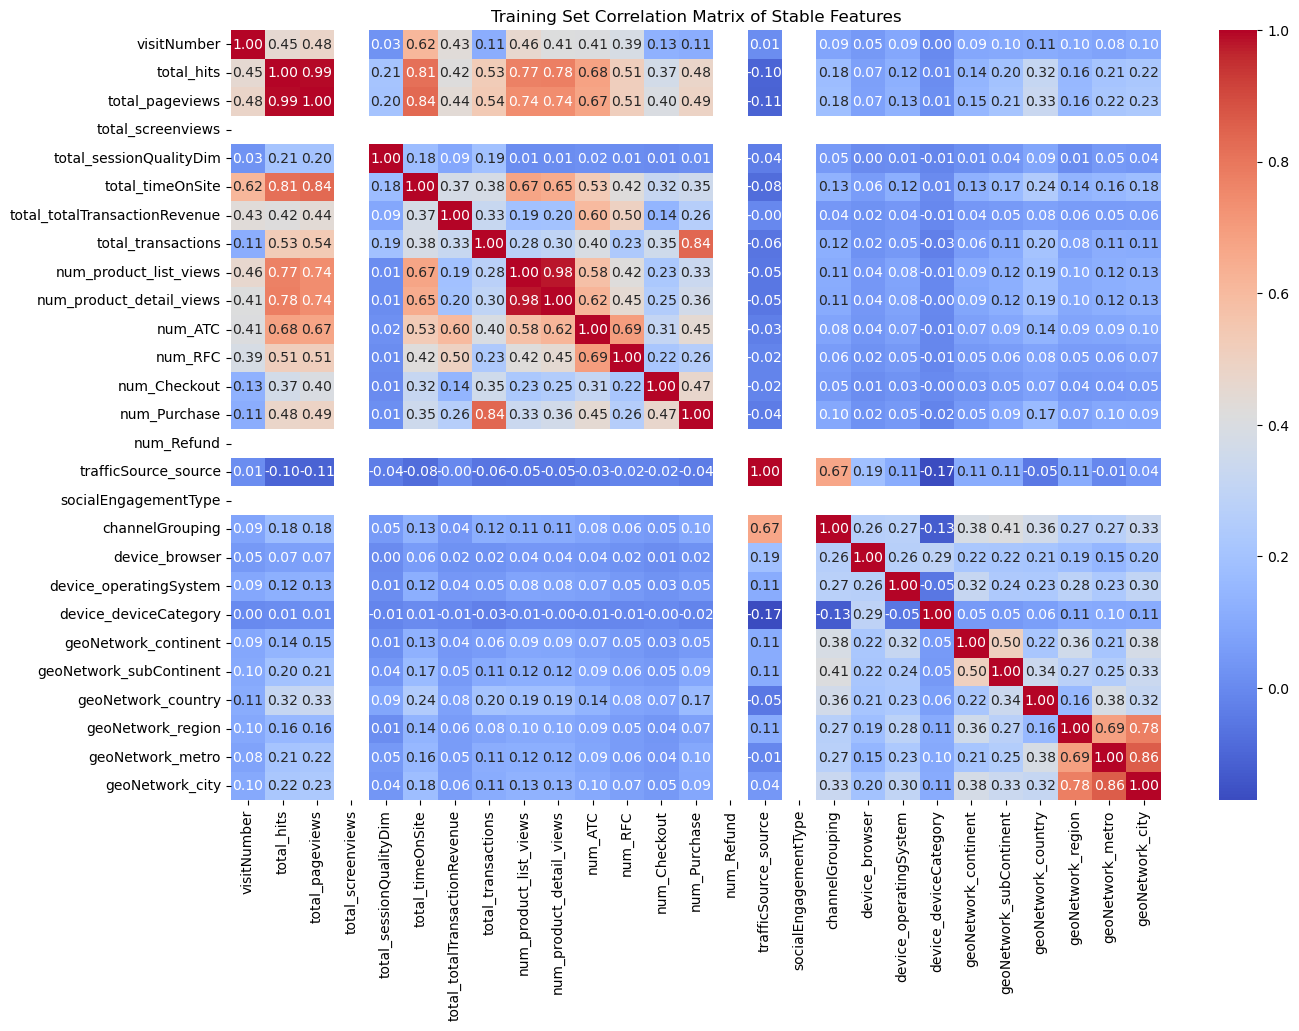

In [9]:
# Plot correlation matrices for stable features in training set
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stable_df = pd.DataFrame(X_train_stable, columns=numeric_columns+non_numeric_columns)
corr_matrix = stable_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Training Set Correlation Matrix of Stable Features')
plt.show()

## Model Fitting and Architecture

For our baseline, we will use only the stable feature in our logisctic regression model. We want to create a binary proability outcome prediction on the likelihood if a user will return or not.  We will also keep track of precision, recall, and accuracy to be used later when comparing model performance against our advanced LSTM model.

### Baseline Logistic Regression

In [ ]:
# Defining baseline model

def log_model(stable_features, learning_rate):
    
    keras.backend.clear_session()
    tf.random.set_seed(0)

    # initialize a sequential model 
    model = Sequential()
    model.add(Dense(
        units = 1, # binary prediction for each month
        input_shape = [stable_features],
        use_bias= True, 
        activation = 'sigmoid',
        kernel_initializer = tf.ones_initializer,
        bias_initializer= tf.ones_initializer
    ))

    # setting optimizer
    optimizer = keras.optimizers.Adam(learning_rate= learning_rate) 

    # tracking precison, recall, accuracy in model compilation 
    model.compile(
        optimizer = optimizer, 
        loss = 'binary_crossentropy',
        metrics = [
            BinaryAccuracy(name = 'accuracy'),
            Recall(name = 'recall'),
            Precision(name = 'precision'),
            AUC(name = 'auc'),
            AUC(name = 'prc', curve = 'PR')
            ]
    )

    return model

Here we build the model using a set of default parameters -- learning rate 1e-3 and 5 epochs. Our goal is to use the simplest parameters for our logisitic regression model.

In [ ]:
# define basic parameters
stable_shape = X_train_stable_scaled.shape[1]
learning_rate = 0.001
epoch = 5

baseline_model = log_model(stable_features=stable_shape, learning_rate= learning_rate)

# fitting model for 5 epochs
history_base = baseline_model.fit(
    x = X_train_stable_scaled,
    y = y_train,
    epochs = epoch, 
    validation_data = (X_val_stable_scaled, y_val),
    batch_size = 64,
    verbose  = 1
)

In [ ]:
# df table of model performance
model_table = pd.DataFrame({
    'Model': ['Baseline'],
    'Loss': [history_base.history['loss'][-1]],
    'Accuracy': [history_base.history['accuracy'][-1]],
    'Precision': [history_base.history['precision'][-1]],
    'Recall': [history_base.history['recall'][-1]]
})

model_table


#### Baseline model evaution

In [ ]:
# plot definition for loss and accuracy

def plot_loss(history): # defining loss curve
    plt.plot(history.history['loss'], label = 'training loss',  color = 'b', marker = 'o')
    plt.plot(history.history['val_loss'], label = 'validation loss',  linestyle =  '--', color = 'r', marker = '>')
    plt.title('Baseline Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.grid(True)
    sns.set_theme(style='dark')
    plt.tight_layout()
    plt.show()


def plot_accuracy(history): # defining accuracy curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='training acc', color = 'b', marker = 'o')
    plt.plot(val_accuracy, label='validation acc',  linestyle =  '--', color = 'r', marker = '>')
    plt.title("Baseline Model Train vs Val Accuracy %")
    plt.xlabel('Train epochs')
    plt.ylabel('Accuracy %')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Plotting both the loss and accuracy curve, the model shows resonable performance as a baseline. We see accuracy higher close to 80% after only 5 epochs. We also generated a confusion matrix to visualized our label predicitons.

In [ ]:
# loss curve
plot_loss(history_base)

In [ ]:
# accuracy curve
plot_accuracy(history_base)

In [ ]:
# generating  trian prediction labels for confusion matrix
train_baseline_mod_pred = baseline_model.predict(X_train_stable_scaled)
train_baseline_mod_label = (train_baseline_mod_pred >= 0.5)

In [ ]:
# evaluating train data
train_loss, train_acc,train_recall, train_precision, *_ = baseline_model.evaluate(X_train_stable_scaled, y_train)

In [ ]:
print(f"""Baseline model Train Accuracy: {train_acc:.2%},
Baseline model Train loss: {train_loss}
Baseline model Train Precision: {train_precision:.2%}
Baseline model Train Recall: {train_recall:.2%}""")

In [ ]:
# confusion matrix
cm = confusion_matrix(y_train, train_baseline_mod_label)
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Not Returning', 'Returning']).plot(
        cmap = 'Blues'
    )
plt.title('Train User Return Predictions')
plt.show()

#### Testing our Baseline

In [ ]:
# generating test labels for confusion matrix
test_baseline_mod_pred = baseline_model.predict(X_test_stable_scaled)
test_baseline_mod_label = (test_baseline_mod_pred >= 0.5)

In [ ]:
# storing precisoin, accuracy, recall, loss for test data
test_loss, test_acc,test_recall, test_precision, *_ = baseline_model.evaluate(X_test_stable_scaled, y_test)

In [ ]:
print(f"""Baseline model Test Accuracy: {test_acc:.2%},
Baseline model Test loss: {test_loss}
Baseline model Test Precision: {test_precision:.2%}
Baseline model Test Recall: {test_recall:.2%}""")

In [ ]:
# confusion matrix for test labels

cm = confusion_matrix(y_test, test_baseline_mod_label)
ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Not Returning', 'Returning']).plot(
        cmap = 'Blues'
    )
plt.title('User Predictions Confusion Matrix')
plt.show()

In [ ]:
# ROC curve
f, axs = plt.subplots(1,1, figsize = (12,6))


RocCurveDisplay.from_predictions(
    y_test,
    test_baseline_mod_pred,
    ax=axs,
    name="ROC curve",
)
axs.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
axs.set_title('Receiver Operating Characteristic (ROC) Curve')
axs.set_xlabel('False Positive Rate (Sensitiviy)')
axs.set_ylabel('True Positive Rate (Specificity)')
axs.grid(True)
axs.legend()

plt.tight_layout()
plt.show()

## LSTM MODEL

Below is the initial fitting of the lstm model before hyperparameter tuning takes place. X_train and X_val needed to be transposed to fit the shape expected by the model, then is inputted into the model architecture. The model architecture begins with the dynamic features that change over time, include a masking layer to tell the model to ignore the 0s in future timesteps, and then the lstm layer, which processes the sequential data. Then the stable features are combined with the model and a final sgmoid activation produces the logits for prediction. Preliminary model performs well with a recall of ~ 88%, but the model architecture will still be tuned in the following section. 

In [ ]:
# reshaping data to work with algorithm (samples, features, timesteps) -> (samples, timesteps, features)
# Reshape X_train_scaled
X_train_scaled = np.transpose(X_train_scaled, (0, 2, 1))

# Reshape X_val_scaled
X_val_scaled = np.transpose(X_val_scaled, (0, 2, 1))


## Defining Model

# Input for dynamic features (x_train.shape (samples, features, timesteps))
dynamic_input = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
x = Masking(mask_value=0)(dynamic_input)  # Masking layer to ignore future timesteps
x = LSTM(units=50, return_sequences=False)(x) # the parantheses here are telling the function to apply only to the dynamic features


# Input for stable features
stable_input = Input(shape=(X_train_stable.shape[1],))


# Concatenate LSTM output with stable features
x = Concatenate()([x, stable_input])

# TimeDistributed Dense layer to get prediction for each timestep
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[dynamic_input, stable_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['recall'])
# should look as recall because we care more about correctly catching attrition over falsely claiming someone will attrit

# Train the model
model.fit([X_train_scaled, X_train_stable_scaled], y_train, epochs=10, validation_data=([X_val_scaled, X_val_stable_scaled], y_val))


In [ ]:
# saving model and test_sets

# Save the model
model.save('preliminary_lstm_model.keras')


# Save X_test
np.save('X_test_scaled.npy', X_test_scaled)
# Save X_test_stable
np.save('X_test_stable_scaled.npy', X_test_stable_scaled)
# Save y_test
np.save('y_test.npy', y_test)



In [ ]:


#loading model and test sets


# Load the model
loaded_model = load_model("preliminary_lstm_model.keras")



# load X_test
np.load('X_test_scaled.npy', X_test_scaled)
# load X_test_stable
np.load('X_test_stable_scaled.npy', X_test_stable_scaled)
# load y_test
np.load('y_test.npy', y_test)


# Verify the model by checking its summary
loaded_model.summary()



# Reshape X_test_scaled
X_test_scaled = np.transpose(X_test_scaled, (0, 2, 1))


# Use the loaded model for predictions
predictions = loaded_model.predict([X_test_scaled, X_test_stable_scaled])
print(predictions)

## Hyperparameter Tuning

The preliminary model fitting performs well, but there are various hyperparameter configurations that can be tested. We had not initially added a dropout layer, which, if added, could strengthen our model generalizability. Additionally, an extra dense layer may help make predictions more robust by capturing non-linear relationships between the features at varying timepoints. Of course the batch size and learning  rate could be modified as well.

Below we test out slight variations to these hyperparameters. Unfortunately due to time restrictions, we were unable to test a wider wariety of hyperparameters. That said, our final performance metrics perform above epectation, with our best performing model having a recall score of ~93%.

In [ ]:
# creating a function that we can use for hyperparameter tuning, 

def create_and_train_model(X_train_scaled, X_train_stable_scaled, y_train, X_val_scaled, X_val_stable_scaled, y_val,
                           lstm_units=50, dropout_rate=0.0, additional_dense_units=None,
                           epochs=10, batch_size=32, learning_rate=0.001, model_path='best_model.keras'):

    # Input for dynamic features
    dynamic_input = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))  # (timesteps, features)
    x = Masking(mask_value=0)(dynamic_input)  # Masking layer to ignore padded timesteps
    x = LSTM(units=lstm_units, return_sequences=False)(x)  # LSTM layer


    # Add a Dropout layer if specified
    if dropout_rate > 0.0:
        x = Dropout(rate=dropout_rate)(x)


    # Input for stable features
    stable_input = Input(shape=(X_train_stable.shape[1],))

    # Concatenate LSTM output with stable features
    x = Concatenate()([x, stable_input]) 

    # Add an additional Dense layer if specified
    if additional_dense_units:
        x = Dense(additional_dense_units, activation='relu')(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Define the model
    model = Model(inputs=[dynamic_input, stable_input], outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint(model_path, monitor='val_recall', save_best_only=True, mode='max')

    # Train the model
    history = model.fit([X_train_scaled, X_train_stable_scaled], y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=([X_val_scaled, X_val_stable_scaled], y_val), callbacks=[checkpoint])

    # Get the final accuracy and recall from the history object
    final_recall = history.history['val_recall'][-1]

    return final_recall, model_path




In [ ]:
# hyperparameter tuning 

# Define the hyperparameters to test
lstm_units_options = [50]
dropout_rate_options = [0.2, 0.5]
additional_dense_units_options = [None, 50]
epochs_options = [10, 15]
batch_size_options = [32]
learning_rate_options = [0.001, 0.0001]

# Create a list to store the results
results = []

# Variable to keep track of the best model
best_model_path = ''
best_recall = -1




# Iterate through all combinations of hyperparameters
for lstm_units in lstm_units_options:
    for dropout_rate in dropout_rate_options:
        for additional_dense_units in additional_dense_units_options:
            for epochs in epochs_options:
                for batch_size in batch_size_options:
                    for learning_rate in learning_rate_options:
                        print(f"Training with lstm_units={lstm_units}, "
                                f"dropout_rate={dropout_rate}, additional_dense_units={additional_dense_units}, "
                                f"epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}")

                        # Define model file path
                        model_path = f'model_lstm{lstm_units}__dropout{dropout_rate}_dense{additional_dense_units}_epochs{epochs}_batch{batch_size}_lr{learning_rate}.keras'

                        # Train the model with the current hyperparameters
                        recall, saved_model_path = create_and_train_model(
                            X_train_scaled, X_train_stable_scaled, y_train,
                            X_val_scaled, X_val_stable_scaled, y_val,
                            dropout_rate=dropout_rate,
                            additional_dense_units=additional_dense_units,
                            epochs=epochs,
                            batch_size=batch_size,
                            learning_rate=learning_rate,
                            model_path=model_path)

                        # Append the results to the list
                        results.append({
                            'lstm_units': lstm_units,
                            'dropout_rate': dropout_rate,
                            'additional_dense_units': additional_dense_units,
                            'epochs': epochs,
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'recall': recall,
                            'model_path': saved_model_path
                        })

                        # Update the best model path if this model has the best recall
                        if recall > best_recall:
                            best_recall = recall
                            best_model_path = saved_model_path

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)
print(f'The best model is saved at: {best_model_path}')

In [ ]:

# loading in the best performing model
loaded_model = load_model('model_lstm50__dropout0.2_dense50_epochs10_batch32_lr0.001.keras')
loaded_model


# Use the loaded model for predictions
predictions = loaded_model.predict([X_test_scaled, X_test_stable_scaled])
print(predictions)


# Binarize predictions (assuming a threshold of 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Flatten predictions and true labels if they are in the shape (samples, 1)
binary_predictions = binary_predictions.flatten()
y_test = y_test

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Calculate precision
precision = precision_score(y_test, binary_predictions)

# Calculate recall
recall = recall_score(y_test, binary_predictions)


print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


## Evaluation Metrics

In [ ]:
## placeholder